Simple implementation of MNIST with TAP-SGM

In [8]:
import numpy as np
import os
import argparse
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from models.unet import UNet

In [12]:
## FFJORD things
import lib.layers as layers
import lib.utils as utils
import lib.odenvp as odenvp
import lib.multiscale_parallel as multiscale_parallel

from train_misc import standard_normal_logprob
from train_misc import set_cnf_options, count_nfe, count_parameters, count_total_time
from train_misc import add_spectral_norm, spectral_norm_power_iteration
from train_misc import create_regularization_fns, get_regularization, append_regularization_to_log


In [24]:
def ffjord_create_model(args, data_shape, regularization_fns):
    hidden_dims = tuple(map(int, args.dims.split(",")))
    strides = tuple(map(int, args.strides.split(",")))

    if args.multiscale:
        model = odenvp.ODENVP(
            (args.batch_size, *data_shape),
            n_blocks=args.num_blocks,
            intermediate_dims=hidden_dims,
            nonlinearity=args.nonlinearity,
            alpha=args.alpha,
            cnf_kwargs={"T": args.time_length, "train_T": args.train_T, "regularization_fns": regularization_fns},
        )
    elif args.parallel:
        model = multiscale_parallel.MultiscaleParallelCNF(
            (args.batch_size, *data_shape),
            n_blocks=args.num_blocks,
            intermediate_dims=hidden_dims,
            alpha=args.alpha,
            time_length=args.time_length,
        )
    else:
        if args.autoencode:

            def build_cnf():
                autoencoder_diffeq = layers.AutoencoderDiffEqNet(
                    hidden_dims=hidden_dims,
                    input_shape=data_shape,
                    strides=strides,
                    conv=args.conv,
                    layer_type=args.layer_type,
                    nonlinearity=args.nonlinearity,
                )
                odefunc = layers.AutoencoderODEfunc(
                    autoencoder_diffeq=autoencoder_diffeq,
                    divergence_fn=args.divergence_fn,
                    residual=args.residual,
                    rademacher=args.rademacher,
                )
                cnf = layers.CNF(
                    odefunc=odefunc,
                    T=args.time_length,
                    regularization_fns=regularization_fns,
                    solver=args.solver,
                )
                return cnf
        else:

            def build_cnf():
                diffeq = layers.ODEnet(
                    hidden_dims=hidden_dims,
                    input_shape=data_shape,
                    strides=strides,
                    conv=args.conv,
                    layer_type=args.layer_type,
                    nonlinearity=args.nonlinearity,
                )
                odefunc = layers.ODEfunc(
                    diffeq=diffeq,
                    divergence_fn=args.divergence_fn,
                    residual=args.residual,
                    rademacher=args.rademacher,
                )
                cnf = layers.CNF(
                    odefunc=odefunc,
                    T=args.time_length,
                    train_T=args.train_T,
                    regularization_fns=regularization_fns,
                    solver=args.solver,
                )
                return cnf

        chain = [layers.LogitTransform(alpha=args.alpha)] if args.alpha > 0 else [layers.ZeroMeanTransform()]
        chain = chain + [build_cnf() for _ in range(args.num_blocks)]
        if args.batch_norm:
            chain.append(layers.MovingBatchNorm2d(data_shape[0]))
        model = layers.SequentialFlow(chain)
    return model

In [25]:
# import MNIST samples

transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST('mnist_data',train = True,download = True, transform = transform)



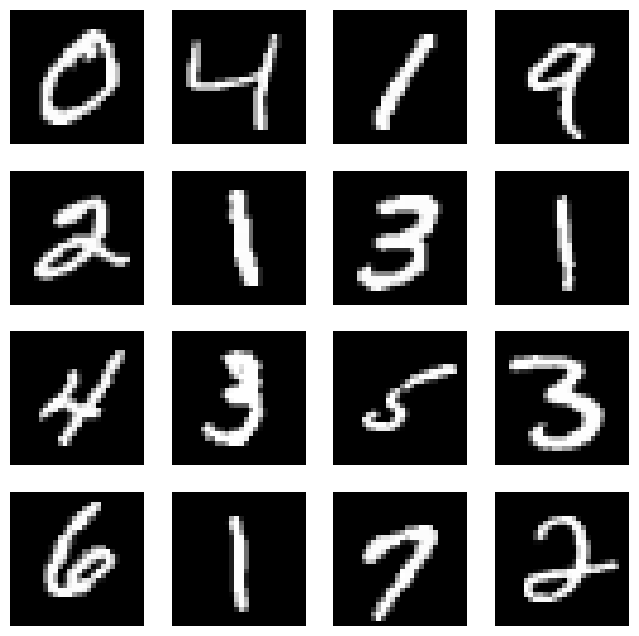

In [26]:
nrows = 4
ncols = 4
fig = plt.figure(figsize=(8,8))
i = 1
for a in range(nrows):
    for b in range(ncols):
        fig.add_subplot(nrows,ncols,i)
        plt.imshow(dataset[i][0][0],cmap = 'gray')
        i = i+1
        plt.axis('off')


In [27]:
## Define scorenetwork 

inputchannels = 1
inputheight = 28
dimx = inputchannels * inputheight ** 2
scorenet = UNet(input_channels = inputchannels,
                input_height = inputheight,
                ch = 32,
                ch_mult = (1,2,2),
                num_res_blocks=2,
                attn_resolutions=(16,),
                resamp_with_conv=True,
                )

In [28]:
## Load preconditioning map

checkpoint = torch.load('ffjord_mnist_bad_checkpt.pth',map_location = torch.device('cpu'))
preconditionerargs = checkpoint['args']

data_shape = (inputchannels, inputheight, inputheight)

regularization_fns, regularization_coeffs = create_regularization_fns(preconditionerargs)
model = ffjord_create_model(preconditionerargs,data_shape,regularization_fns)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cvt = lambda x: x.type(torch.float32).to(device, non_blocking=True)
fixed_z = cvt(torch.randn(16, *data_shape))

ffjord_generated_samples = model(fixed_z, reverse=True).view(-1, *data_shape)


/Users/bjzhang/gitrepos/tap-sgm/mymnist/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


In [48]:
## Pushforward samples

torch.Size([16, 1, 28, 28])

In [103]:
loader = torch.utils.data.DataLoader(dataset,60000)
blah = enumerate(loader)
a, (blah,b) = next(blah)

pushforward_z = model(blah,reverse = False).view(-1,*data_shape)

/Users/bjzhang/gitrepos/tap-sgm/mymnist/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


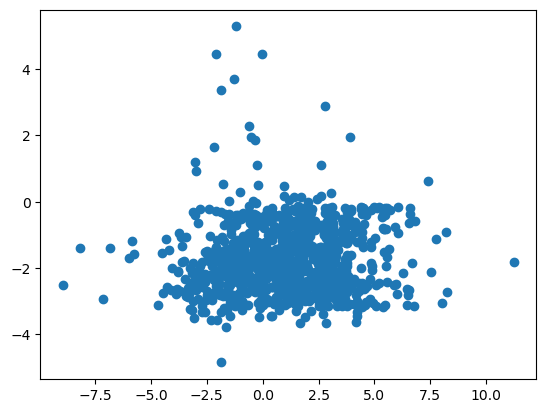

In [156]:
pushforward_z.shape
bleh = pushforward_z.detach().numpy()
bleh[4,:,1,1]
plt.scatter(bleh[:,0,14,10],bleh[:,0,4,1])

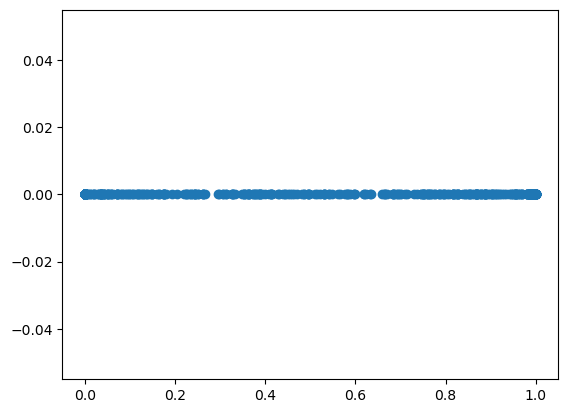

In [157]:
scattersamples = blah.detach().numpy()

plt.scatter(scattersamples[:,0,14,10],scattersamples[:,0,4,1])

In [164]:
print(torch.cuda.is_available())


False


In [ ]:
# Scorenet is a U-net, whatever that is. 

## FIGURE OUT SCORENET NEXT

## THEN FIGURE OUT THE PRETRAINED THING

##LOOK AT 2D MARGINALS OF THE BAD FFJORDMAP